# DDPG (Deep Deterministic Policy Gradient)

## Введение

До сих пор мы применяли методы градиента политики (on-policy) для работы с непрерывными пространствами действий. (Эти методы затем привели к современным алгоритмам, таким как PPO - Proximal Policy Optimization)

**DDPG (Deep Deterministic Policy Gradient)** также использует градиент политики и архитектуру Actor-Critic, но имеет ключевые отличия:

1. **Детерминистическая политика**: В отличие от стохастических политик в on-policy методах, DDPG использует детерминистическую политику, которая для каждого состояния возвращает конкретное действие (а не распределение вероятностей)

2. **Off-policy алгоритм**: DDPG может обучаться на данных, собранных с помощью другой (старой) политики, что делает его более эффективным в использовании данных

3. **Непрерывные действия**: Алгоритм специально разработан для задач с непрерывным пространством действий, что делает его идеальным для робототехники и управления

In [15]:
# !pip install torch==1.13.1 --extra-index-url https://download.pytorch.org/whl/cpu

In [16]:
# !pip install numpy matplotlib

In [17]:
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
from torch.nn import functional as F

from tqdm import tqdm 

## О непрерывном пространстве действий

DDPG не может работать с дискретным пространством действий, поэтому здесь мы используем кастомную реализацию CartPole с непрерывным пространством действий.

**Пространство действий** в этом примере имеет вид: ```Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)```

Это означает:
- Действие представляет собой одно вещественное число (shape=(1,))
- Значение действия ограничено диапазоном от -1.0 до 1.0
- Это соответствует силе, прикладываемой к тележке (отрицательное значение - влево, положительное - вправо)

In [18]:
from util.cartpole import CartPole
env = CartPole()

## Математические основы DDPG

### Уравнение Беллмана

Начнем с уравнения Беллмана, которое обсуждалось в `Q-Learning`:

$$ Q^{*}(s_t,a_t) = r_t + \gamma \max_a{Q(s_{t+1},a)} \;\;\;\;\;\; (1)$$

где $ Q^{*} $ означает оптимальное значение Q-функции.

### Q-сеть и функция потерь

Теперь рассмотрим Q-сеть $ Q_{\phi} $, где $\phi$ - параметры сети.

Для оптимизации уравнения (1) нужно найти $\phi$, минимизируя следующую функцию потерь $L$ для кортежей $ (s_t, a_t, r_t, s_{t+1}, d_t) $:

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \max_a{Q_{\phi}(s_{t+1},a)} \right) \right)^2 \right] \;\;\;\;\;\; (2)$$

где $d_t = 1$, если эпизод завершен, и $0$ в противном случае.

### Проблема непрерывного пространства действий

В непрерывном пространстве действий операция $\max_a Q_{\phi}(s_{t+1}, a)$ становится проблематичной, так как нельзя перебрать все возможные действия.

**Решение**: Вводим детерминистическую политику $\mu_{\theta}(s)$, которая для каждого состояния возвращает оптимальное действие. Теперь мы ищем $\theta$, максимизируя $ Q_{\phi}(s, \mu_{\theta}(s)) $.

Уравнение (2) переписывается следующим образом:

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) Q_{\phi}(s_{t+1},\mu_{\theta}(s_{t+1})) \right) \right)^2 \right] \;\;\;\;\;\; (3) $$

> **Важно**: Это основано на методе `Actor-Critic`, который разделяет политику ($\mu_{\theta}$ - Actor) и оценку ценности ($Q_{\phi}$ - Critic).

### Ключевое отличие от on-policy методов

Обратите внимание на разницу между политикой $\mu_{\theta}(s)$ в DDPG и политикой в `on-policy` методах:

- **DDPG**: $\mu_{\theta}(s)$ - детерминистическая функция, возвращающая конкретное действие
- **On-policy**: $P(a | \pi_\theta(s))$ - стохастическое распределение вероятностей действий

DDPG называется "детерминистическим" и является off-policy методом, что позволяет обучаться на данных, собранных другой политикой.

### Целевые сети (Target Networks) для стабильности

Для стабилизации обучения вводим отдельные параметры $\phi^{\prime}$ и $\theta^{\prime}$ (называемые **целевыми сетями**):

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) Q_{{\phi}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] \;\;\;\;\;\; (4) $$

Целевые параметры обновляются медленно с помощью коэффициента $\tau$ (гиперпараметр, близкий к 0) после каждого шага обучения:

$ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $

$ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

Это **мягкое обновление** (soft update) предотвращает резкие изменения целевых значений и стабилизирует обучение.

### Алгоритм DDPG (краткое резюме)

1. **Сбор данных**: Собираем кортежи $ (s_t, a_t, r_t, s_{t+1}, d_t) $ в replay buffer
2. **Обучение Critic**: Оптимизируем $\phi$ для минимизации $L$ в (4)
3. **Обучение Actor**: Оптимизируем $\theta$ для максимизации $Q_{\phi}(s, \mu_{\theta}(s))$
4. **Обновление целевых сетей**: Мягко обновляем целевые параметры
    - $ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $
    - $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

Теперь приступим к построению сетей.

## 1. Q-сеть (Critic Network)

Q-сеть (также называемая Critic) оценивает качество действия $a$ в состоянии $s$ через функцию $Q_{\phi}(s, a)$.

**Архитектура**:
- Вход: состояние $s$ (4 измерения для CartPole) + действие $a$ (1 измерение)
- Скрытый слой: полносвязный слой с ReLU активацией
- Выход: одно число - оценка Q-значения

Мы создаем две идентичные Q-сети:
- `q_origin_model`: основная сеть $Q_{\phi}(s, a)$ для обучения
- `q_target_model`: целевая сеть $Q_{\phi^{\prime}}(s, a)$ для стабильного обучения

In [ ]:
# Выбираем устройство для вычислений (GPU если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNet(nn.Module):
    """
    Q-сеть (Critic) для оценки Q(s, a) - ожидаемого будущего вознаграждения
    при выполнении действия a в состоянии s.
    
    Args:
        hidden_dim: размерность скрытого слоя (по умолчанию 64)
    """
    def __init__(self, hidden_dim=64):
        super().__init__()
        # Входной размер: 4 (состояние) + 1 (действие) = 5
        self.hidden = nn.Linear(5, hidden_dim)
        # Выходной размер: 1 (Q-значение)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s, a):
        """
        Прямой проход через сеть.
        
        Args:
            s: тензор состояний [batch_size, 4]
            a: тензор действий [batch_size, 1]
        
        Returns:
            Q-значения [batch_size, 1]
        """
        # Объединяем состояние и действие
        outs = torch.concat((s, a), dim=-1)  # [batch_size, 5]
        # Проходим через скрытый слой с ReLU активацией
        outs = self.hidden(outs)
        outs = F.relu(outs)
        # Получаем Q-значение
        outs = self.output(outs)
        return outs

# Создаем основную Q-сеть для обучения (Q_phi)
q_origin_model = QNet().to(device)
# Создаем целевую Q-сеть (Q_phi') - копия основной сети
q_target_model = QNet().to(device)
# Отключаем градиенты для целевой сети (она обновляется через soft update)
_ = q_target_model.requires_grad_(False)

## 2. Политика (Actor Network)

Политика (также называемая Actor) определяет, какое действие выбрать в данном состоянии. Это детерминистическая функция $\mu_{\theta}(s)$, которая возвращает оптимальное действие для состояния $s$.

**Архитектура**:
- Вход: состояние $s$ (4 измерения для CartPole)
- Скрытый слой: полносвязный слой с ReLU активацией
- Выход: действие $a$ (1 измерение), активированное через `tanh()` для ограничения диапазона

**Важно**: Пространство действий ```Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)```, поэтому используем `tanh()` для ограничения выхода в диапазон [-1, 1].

Мы создаем две идентичные сети политики:
- `mu_origin_model`: основная сеть $\mu_{\theta}(s)$ для обучения
- `mu_target_model`: целевая сеть $\mu_{\theta^{\prime}}(s)$ для стабильного обучения

In [ ]:
class PolicyNet(nn.Module):
    """
    Сеть политики (Actor) для определения действия в состоянии s.
    Возвращает детерминистическое действие (не распределение вероятностей).
    
    Args:
        hidden_dim: размерность скрытого слоя (по умолчанию 64)
    """
    def __init__(self, hidden_dim=64):
        super().__init__()
        # Входной размер: 4 (состояние CartPole)
        self.hidden = nn.Linear(4, hidden_dim)
        # Выходной размер: 1 (действие)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        """
        Прямой проход через сеть.
        
        Args:
            s: тензор состояний [batch_size, 4]
        
        Returns:
            Действия [batch_size, 1] в диапазоне [-1, 1]
        """
        # Проходим через скрытый слой с ReLU активацией
        outs = self.hidden(s)
        outs = F.relu(outs)
        # Получаем действие
        outs = self.output(outs)
        # Ограничиваем действие в диапазон [-1, 1] с помощью tanh
        # Это соответствует пространству действий Box(low=-1.0, high=1.0)
        outs = torch.tanh(outs)
        return outs

# Создаем основную сеть политики для обучения (mu_theta)
mu_origin_model = PolicyNet().to(device)
# Создаем целевую сеть политики (mu_theta') - копия основной сети
mu_target_model = PolicyNet().to(device)
# Отключаем градиенты для целевой сети (она обновляется через soft update)
_ = mu_target_model.requires_grad_(False)

## 3. Функция оптимизации параметров сетей $\phi, \theta$

Функция `optimize` выполняет один шаг обучения для обеих сетей:

1. **Обучение Critic ($\phi$)**: Минимизируем функцию потерь $L$ из уравнения (4)
   - Вычисляем текущие Q-значения: $Q_{\phi}(s_t, a_t)$
   - Вычисляем целевые Q-значения: $r_t + \gamma (1 - d_t) Q_{\phi^{\prime}}(s_{t+1}, \mu_{\theta^{\prime}}(s_{t+1}))$
   - Минимизируем MSE между ними

2. **Обучение Actor ($\theta$)**: Максимизируем $Q_{\phi}(s, \mu_{\theta}(s))$
   - Используем текущую политику $\mu_{\theta}(s)$ для получения действий
   - Максимизируем Q-значения этих действий (минимизируем отрицательные Q-значения)
   - Важно: временно отключаем градиенты Q-сети при обучении Actor

In [ ]:
# Коэффициент дисконтирования для будущих вознаграждений
gamma = 0.99

# Оптимизаторы для обеих сетей
opt_q = torch.optim.AdamW(q_origin_model.parameters(), lr=0.0005)  # для Critic
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.0005)  # для Actor

def optimize(states, actions, rewards, next_states, dones):
    """
    Выполняет один шаг обучения для Critic и Actor сетей.
    
    Args:
        states: список текущих состояний
        actions: список выполненных действий
        rewards: список полученных вознаграждений
        next_states: список следующих состояний
        dones: список флагов завершения эпизода
    """
    # Преобразуем данные в тензоры PyTorch
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    actions = actions.unsqueeze(dim=1)  # [batch_size, 1]
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)  # [batch_size, 1]
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)  # [batch_size, 1]

    # ========== ОБУЧЕНИЕ CRITIC (Q-сеть) ==========
    # Минимизируем функцию потерь L из уравнения (4)
    opt_q.zero_grad()
    
    # Текущие Q-значения: Q_phi(s_t, a_t)
    q_org = q_origin_model(states, actions)
    
    # Вычисляем целевые Q-значения используя целевые сети
    # Действие для следующего состояния: mu_theta'(s_{t+1})
    mu_tgt_next = mu_target_model(next_states)
    # Q-значение следующего состояния: Q_phi'(s_{t+1}, mu_theta'(s_{t+1}))
    q_tgt_next = q_target_model(next_states, mu_tgt_next)
    # Целевое Q-значение: r_t + gamma * (1 - d_t) * Q_phi'(s_{t+1}, mu_theta'(s_{t+1}))
    q_tgt = rewards + gamma * (1.0 - dones) * q_tgt_next
    
    # Функция потерь: MSE между текущими и целевыми Q-значениями
    loss_q = F.mse_loss(q_org, q_tgt, reduction="none")
    loss_q.sum().backward()  # обратное распространение
    opt_q.step()  # обновление параметров phi

    # ========== ОБУЧЕНИЕ ACTOR (политика) ==========
    # Максимизируем Q_phi(s, mu_theta(s))
    opt_mu.zero_grad()
    
    # Получаем действия от текущей политики: mu_theta(s)
    mu_org = mu_origin_model(states)
    
    # Временно отключаем градиенты Q-сети при обучении Actor
    # Это нужно, чтобы градиенты не распространялись обратно в Q-сеть
    for p in q_origin_model.parameters():
        p.requires_grad = False
    
    # Вычисляем Q-значения для действий от текущей политики
    q_tgt_max = q_origin_model(states, mu_org)
    # Максимизируем Q-значения (минимизируем отрицательные)
    (-q_tgt_max).sum().backward()  # обратное распространение
    opt_mu.step()  # обновление параметров theta
    
    # Включаем градиенты Q-сети обратно
    for p in q_origin_model.parameters():
        p.requires_grad = True

## 4. Функция обновления целевых параметров $\phi^{\prime}, \theta^{\prime}$

Целевые сети обновляются через **мягкое обновление** (soft update) с коэффициентом $\tau$:

- $ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $
- $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

**Почему это важно?**
- $\tau$ обычно очень мал (например, 0.002), что означает медленное обновление целевых сетей
- Это предотвращает резкие изменения целевых значений и стабилизирует обучение
- Без целевых сетей обучение может быть нестабильным из-за постоянно меняющихся целевых значений

In [ ]:
# Коэффициент мягкого обновления (обычно очень мал, например 0.001-0.01)
tau = 0.002

def update_target():
    """
    Выполняет мягкое обновление целевых сетей.
    
    Обновляет параметры целевых сетей как взвешенную комбинацию
    текущих параметров основных сетей и старых параметров целевых сетей.
    
    Формула: target = tau * origin + (1 - tau) * target
    где tau << 1, что обеспечивает медленное обновление.
    """
    # Обновляем параметры целевой Q-сети
    for var, var_target in zip(q_origin_model.parameters(), q_target_model.parameters()):
        # var: параметр основной сети (phi)
        # var_target: параметр целевой сети (phi')
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    
    # Обновляем параметры целевой сети политики
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        # var: параметр основной сети (theta)
        # var_target: параметр целевой сети (theta')
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

## 5. Replay Buffer (Буфер воспроизведения)

**Проблема on-policy методов**: В архитектуре on-policy мы используем последовательные выборки (траектории) для каждого батча обучения. Это означает, что модель обучается только на недавних данных.

**Решение в DDPG**: Используем **replay buffer** (буфер воспроизведения) для хранения прошлого опыта в виде кортежей $ (s_t, a_t, r_t, s_{t+1}, d_t) $.

**Преимущества replay buffer**:
- **Off-policy обучение**: Можем обучаться на данных, собранных старой политикой
- **Устранение корреляции**: Случайная выборка из буфера разрывает временную корреляцию между последовательными состояниями
- **Эффективное использование данных**: Каждый опыт может быть использован многократно
- **Стабильность**: Обучение на разнообразных данных из разных эпизодов делает процесс более стабильным

**Как это работает**:
1. Сохраняем каждый опыт $(s_t, a_t, r_t, s_{t+1}, d_t)$ в буфер
2. При обучении случайным образом выбираем батч из буфера
3. Обучаемся на этом батче (не обязательно из текущего эпизода)

In [ ]:
class replayBuffer:
    """
    Буфер воспроизведения для хранения и выборки опыта обучения.
    
    Хранит кортежи (s_t, a_t, r_t, s_{t+1}, d_t) и позволяет
    случайно выбирать батчи для обучения (off-policy).
    """
    def __init__(self, buffer_size: int):
        """
        Args:
            buffer_size: максимальный размер буфера
        """
        self.buffer_size = buffer_size
        self.buffer = []  # список для хранения опыта
        self._next_idx = 0  # индекс для циклической записи

    def add(self, item):
        """
        Добавляет новый опыт в буфер.
        
        Args:
            item: кортеж (s_t, a_t, r_t, s_{t+1}, d_t)
        """
        # Если буфер еще не заполнен, добавляем новый элемент
        if len(self.buffer) > self._next_idx:
            # Если буфер заполнен, перезаписываем старый опыт
            self.buffer[self._next_idx] = item
        else:
            # Иначе добавляем новый элемент
            self.buffer.append(item)
        
        # Циклически обновляем индекс (FIFO - первый пришел, первый ушел)
        if self._next_idx == self.buffer_size - 1:
            self._next_idx = 0
        else:
            self._next_idx = self._next_idx + 1

    def sample(self, batch_size):
        """
        Случайно выбирает батч опыта из буфера.
        
        Args:
            batch_size: размер батча
        
        Returns:
            Кортеж (states, actions, rewards, next_states, dones)
        """
        # Случайно выбираем индексы из текущего размера буфера
        indices = [random.randint(0, len(self.buffer) - 1) for _ in range(batch_size)]
        
        # Извлекаем данные по выбранным индексам
        states   = [self.buffer[i][0] for i in indices]  # текущие состояния
        actions  = [self.buffer[i][1] for i in indices]   # выполненные действия
        rewards  = [self.buffer[i][2] for i in indices]   # полученные вознаграждения
        n_states = [self.buffer[i][3] for i in indices]   # следующие состояния
        dones    = [self.buffer[i][4] for i in indices]   # флаги завершения
        
        return states, actions, rewards, n_states, dones

    def length(self):
        """Возвращает текущий размер буфера."""
        return len(self.buffer)

# Создаем буфер воспроизведения размером 20000 опытов
buffer = replayBuffer(buffer_size=20000)

## 6. Шум для исследования (Exploration Noise)

### Проблема детерминистической политики

Политика $\mu_{\theta}(s)$ является **детерминистической** - для одного и того же состояния она всегда возвращает одно и то же действие. Это создает проблему:

- **Отсутствие исследования**: Без случайности агент будет всегда выбирать одни и те же действия
- **Локальные оптимумы**: Агент может застрять в локальном оптимуме, не исследуя другие стратегии
- **Недостаток данных**: Для обучения нужны разнообразные данные, которые требуют исследования

### Решение: добавление шума

**Решение**: Добавляем шум к действиям политики для исследования пространства действий.

**В DDPG** часто используется **шум Орнштейна-Уленбека** ([Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)):

- **Коррелированный шум**: В отличие от белого шума, OU-шум имеет "память" - следующее значение зависит от предыдущего
- **Возврат к среднему**: Шум стремится вернуться к среднему значению (обычно 0)
- **Естественность**: Для физических систем (робототехника) такой шум более естественен, чем независимый белый шум

**Формула OU-процесса**:
$$ dx_t = \theta(\mu - x_{t-1})dt + \sigma dW_t $$

где:
- $\theta$ - скорость возврата к среднему
- $\mu$ - среднее значение (обычно 0)
- $\sigma$ - волатильность шума
- $dW_t$ - винеровский процесс (белый шум)

In [ ]:
"""
Шум Орнштейна-Уленбека для исследования действий.
Реализация от OpenAI.

Скопировано из: https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class OrnsteinUhlenbeckActionNoise:
    """
    Генерирует коррелированный шум для исследования действий.
    
    OU-процесс: dx_t = theta * (mu - x_{t-1}) * dt + sigma * sqrt(dt) * dW_t
    
    Args:
        mu: среднее значение (обычно 0)
        sigma: стандартное отклонение шума
        theta: скорость возврата к среднему (обычно 0.15)
        dt: временной шаг (обычно 0.01)
        x0: начальное значение (если None, то 0)
    """
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta  # скорость возврата к среднему
        self.mu = mu  # среднее значение
        self.sigma = sigma  # волатильность
        self.dt = dt  # временной шаг
        self.x0 = x0  # начальное значение
        self.reset()

    def __call__(self):
        """
        Генерирует следующее значение OU-шума.
        
        Returns:
            Новое значение шума
        """
        # Формула OU-процесса в дискретном виде
        # x_t = x_{t-1} + theta * (mu - x_{t-1}) * dt + sigma * sqrt(dt) * N(0,1)
        x = (self.x_prev + 
             self.theta * (self.mu - self.x_prev) * self.dt + 
             self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape))
        self.x_prev = x
        return x

    def reset(self):
        """Сбрасывает процесс в начальное состояние."""
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

# Создаем генератор OU-шума
# mu=0: среднее значение 0
# sigma=0.05: небольшой шум для плавного исследования
ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

def pick_sample(s):
    """
    Выбирает действие для состояния s с добавлением шума для исследования.
    
    Args:
        s: текущее состояние
    
    Returns:
        Действие в диапазоне [-1, 1] с добавленным шумом
    """
    # Отключаем вычисление градиентов (только инференс)
    with torch.no_grad():
        # Преобразуем состояние в тензор
        s = np.array(s)
        s_batch = np.expand_dims(s, axis=0)  # добавляем размерность батча
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        
        # Получаем детерминистическое действие от политики: mu_theta(s)
        action_det = mu_origin_model(s_batch)
        action_det = action_det.squeeze(dim=1)  # убираем лишнюю размерность
        
        # Добавляем OU-шум для исследования
        noise = ou_action_noise()
        action = action_det.cpu().numpy() + noise
        
        # Ограничиваем действие в допустимый диапазон [-1, 1]
        action = np.clip(action, -1.0, 1.0)
        
        return float(action.item())

## 7. Основной цикл обучения

Теперь объединим все компоненты в единый цикл обучения!

**Важно**: В этом примере обучение происходит на каждом шаге эпизода (после каждого действия). Это может быть медленным, но обеспечивает частые обновления. В реальных задачах можно обучаться реже (например, каждые N шагов или после каждого эпизода).

**Алгоритм обучения**:
1. Инициализируем среду и получаем начальное состояние
2. Для каждого шага эпизода:
   - Выбираем действие с помощью политики + шум
   - Выполняем действие и получаем награду и следующее состояние
   - Сохраняем опыт $(s_t, a_t, r_t, s_{t+1}, d_t)$ в replay buffer
   - Если в буфере достаточно данных, обучаем сети на случайном батче
   - Обновляем целевые сети
3. Повторяем для нескольких эпизодов до достижения хороших результатов

In [ ]:
# Размер батча для обучения
batch_size = 250

# Список для записи наград по эпизодам
reward_records = []

# Основной цикл обучения
for i in tqdm(range(2000)):
    # Запускаем новый эпизод
    s = env.reset()
    done = False
    cum_reward = 0  # накопленная награда в эпизоде
    
    # Выполняем шаги до завершения эпизода
    while not done:
        # Выбираем действие с помощью политики + шум для исследования
        a = pick_sample(s)
        
        # Выполняем действие в среде
        s_next, r, done, _ = env.step(a)
        
        # Сохраняем опыт (s_t, a_t, r_t, s_{t+1}, d_t) в replay buffer
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r

        # Обучаем сети, если в буфере достаточно данных
        if buffer.length() >= batch_size:
            # Случайно выбираем батч из буфера
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            # Выполняем один шаг обучения Critic и Actor
            optimize(states, actions, rewards, n_states, dones)
            # Мягко обновляем целевые сети
            update_target()
        
        # Переходим к следующему состоянию
        s = s_next

    # Записываем награду эпизода (максимум 500 для CartPole)
    reward_records.append(cum_reward)

    # Останавливаем обучение, если средняя награда за последние 50 эпизодов > 475
    # Это означает, что агент научился хорошо решать задачу
    if np.average(reward_records[-50:]) > 475.0:
        print(f"\nОбучение завершено на эпизоде {i}!")
        break

print("\nОбучение завершено!")

100%|██████████| 2000/2000 [04:41<00:00,  7.10it/s]


Done


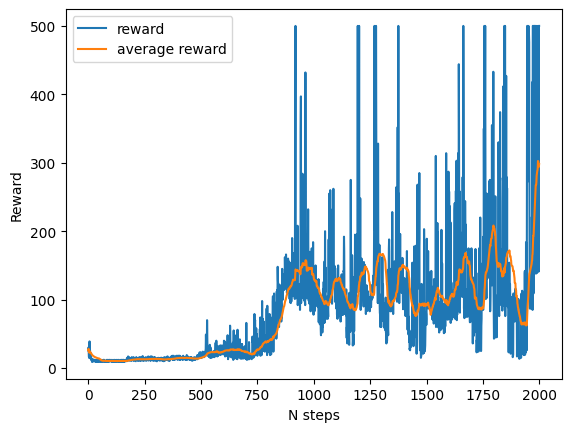

In [ ]:
import matplotlib.pyplot as plt

# Вычисляем скользящее среднее за последние 50 эпизодов
# Это помогает увидеть тренд обучения, сглаживая шум
average_reward = []
for idx in range(len(reward_records)):
    if idx < 50:
        # Если эпизодов меньше 50, берем все доступные
        avg_list = reward_records[:idx+1]
    else:
        # Иначе берем последние 50 эпизодов
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))

# Строим графики
plt.plot(reward_records, label='Награда за эпизод', alpha=0.6)
plt.plot(average_reward, label='Средняя награда (50 эпизодов)', linewidth=2)
plt.xlabel('Номер эпизода')
plt.ylabel('Награда')
plt.title('Обучение DDPG на CartPole')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
q_origin_model = QNet().to(device)  # Q_phi
q_target_model = QNet().to(device)  # Q_phi'
_ = q_target_model.requires_grad_(False)  # target model doen't need grad

In [28]:
mu_origin_model = PolicyNet().to(device)  # mu_theta
mu_target_model = PolicyNet().to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

In [29]:
opt_q = torch.optim.AdamW(q_origin_model.parameters(), lr=0.005)
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.005)

In [30]:
batch_size = 250

reward_records = []
for i in tqdm(range(500)):
    # Run episode till done
    s = env.reset()
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, done, _ = env.step(a)
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r

        # Train (optimize parameters)
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next

    # Output total rewards in episode (max 500)
    # print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")

100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


Done


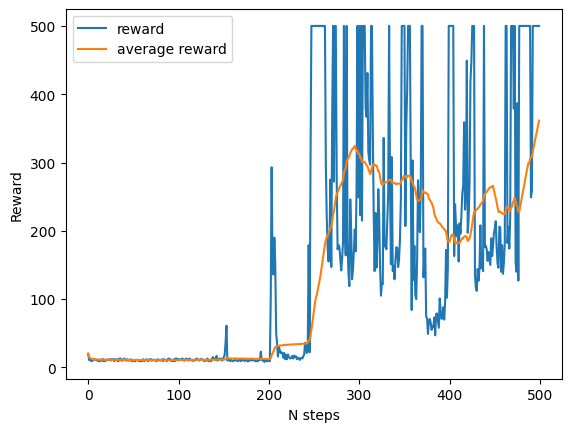

In [31]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N steps')
plt.ylabel('Reward')
plt.legend()
plt.show()

## [Опционально] Clipped Double-Q Learning (Twin-Q)

### Проблема переоценки Q-функции

В стандартном DDPG существует проблема **переоценки Q-значений** (overestimation bias):
- Q-сеть может систематически переоценивать значения действий
- Это приводит к нестабильному обучению и субоптимальной политике
- Проблема усугубляется при использовании максимизации по действиям

### Решение: Double Q-Learning

В продвинутых алгоритмах, таких как **TD3 (Twin Delayed DDPG)**, используются **2 Q-сети** для уменьшения переоценки:

- $ Q_{\phi_1}(s, a), Q_{\phi_2}(s, a) $ - две основные Q-сети
- $ Q_{\phi_1^{\prime}}(s, a), Q_{\phi_2^{\prime}}(s, a) $ - две соответствующие целевые Q-сети

### Идея Clipped Double-Q

**Ключевая идея**: Используем **минимум** из двух Q-сетей для вычисления целевых значений. Это предотвращает переоценку, так как минимум двух оценок обычно более консервативен.

### Алгоритм оптимизации

1. **Обучение Q-сети 1 ($\phi_1$)**:
   $$ \min_{\phi_1} E\left[ \left( Q_{\phi_1}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] $$

2. **Обучение Q-сети 2 ($\phi_2$)**:
   $$ \min_{\phi_2} E\left[ \left( Q_{\phi_2}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] $$

3. **Обучение политики ($\theta$)**:
   $$ \max_{\theta} Q_{\phi_1}(s, \mu_{\theta}(s)) $$
   
   Используем только первую Q-сеть для обучения политики.

### Обновление целевых параметров

- $ \phi_1^{\prime} = \tau \phi_1 + (1-\tau) \phi_1^{\prime} $
- $ \phi_2^{\prime} = \tau \phi_2 + (1-\tau) \phi_2^{\prime} $
- $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

**Преимущества**:
- Уменьшение переоценки Q-значений
- Более стабильное обучение
- Лучшая производительность в сложных задачах

### (1) Создание сетей для Double-Q

Создаем две Q-сети и две целевые Q-сети, а также сети политики (Actor).

In [32]:
q_origin_model1 = QNet().to(device)  # Q_phi1
q_origin_model2 = QNet().to(device)  # Q_phi2
q_target_model1 = QNet().to(device)  # Q_phi1'
q_target_model2 = QNet().to(device)  # Q_phi2'
_ = q_target_model1.requires_grad_(False)  # target model doen't need grad
_ = q_target_model2.requires_grad_(False)  # target model doen't need grad

In [33]:
mu_origin_model = PolicyNet().to(device)  # mu_theta
mu_target_model = PolicyNet().to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

### (2) Функция оптимизации для Double-Q

Обновляем функцию `optimize` для работы с двумя Q-сетями. Ключевое отличие - использование минимума двух целевых Q-значений.

In [ ]:
# Коэффициент дисконтирования
gamma = 0.99

# Оптимизаторы для двух Q-сетей и политики
opt_q1 = torch.optim.AdamW(q_origin_model1.parameters(), lr=0.0005)  # для Q-сети 1
opt_q2 = torch.optim.AdamW(q_origin_model2.parameters(), lr=0.0005)  # для Q-сети 2
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.0005)  # для политики

def optimize(states, actions, rewards, next_states, dones):
    """
    Выполняет один шаг обучения для Double-Q DDPG.
    
    Ключевое отличие от стандартного DDPG: используем минимум двух Q-значений
    для вычисления целевых значений (clipped double-Q).
    
    Args:
        states: список текущих состояний
        actions: список выполненных действий
        rewards: список полученных вознаграждений
        next_states: список следующих состояний
        dones: список флагов завершения эпизода
    """
    # Преобразуем данные в тензоры PyTorch
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    actions = actions.unsqueeze(dim=1)  # [batch_size, 1]
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)  # [batch_size, 1]
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)  # [batch_size, 1]

    # ========== ВЫЧИСЛЕНИЕ ЦЕЛЕВЫХ Q-ЗНАЧЕНИЙ (CLIPPED DOUBLE-Q) ==========
    # Получаем действие для следующего состояния от целевой политики
    mu_tgt_next = mu_target_model(next_states)
    
    # Вычисляем Q-значения следующего состояния от обеих целевых Q-сетей
    q1_tgt_next = q_target_model1(next_states, mu_tgt_next)
    q2_tgt_next = q_target_model2(next_states, mu_tgt_next)
    
    # КЛЮЧЕВОЙ МОМЕНТ: используем МИНИМУМ двух Q-значений
    # Это предотвращает переоценку (overestimation bias)
    q_tgt_next_min = torch.minimum(q1_tgt_next, q2_tgt_next)
    
    # Целевое Q-значение: r_t + gamma * (1 - d_t) * min(Q1, Q2)
    q_tgt = rewards + gamma * (1.0 - dones) * q_tgt_next_min

    # ========== ОБУЧЕНИЕ Q-СЕТИ 1 ==========
    opt_q1.zero_grad()
    q1_org = q_origin_model1(states, actions)
    loss_q1 = F.mse_loss(q1_org, q_tgt, reduction="none")
    loss_q1.sum().backward()
    opt_q1.step()

    # ========== ОБУЧЕНИЕ Q-СЕТИ 2 ==========
    opt_q2.zero_grad()
    q2_org = q_origin_model2(states, actions)
    loss_q2 = F.mse_loss(q2_org, q_tgt, reduction="none")
    loss_q2.sum().backward()
    opt_q2.step()

    # ========== ОБУЧЕНИЕ ACTOR (политика) ==========
    # Используем только первую Q-сеть для обучения политики
    opt_mu.zero_grad()
    mu_org = mu_origin_model(states)
    
    # Временно отключаем градиенты Q-сети 1
    for p in q_origin_model1.parameters():
        p.requires_grad = False
    
    # Максимизируем Q-значения от первой Q-сети
    q_tgt_max = q_origin_model1(states, mu_org)
    (-q_tgt_max).sum().backward()
    opt_mu.step()
    
    # Включаем градиенты обратно
    for p in q_origin_model1.parameters():
        p.requires_grad = True

### (3) Функция обновления целевых параметров для Double-Q

Обновляем функцию `update_target` для работы с двумя целевыми Q-сетями.

In [ ]:
# Коэффициент мягкого обновления
tau = 0.002

def update_target():
    """
    Выполняет мягкое обновление всех целевых сетей для Double-Q DDPG.
    
    Обновляет:
    - Целевую Q-сеть 1 (phi_1')
    - Целевую Q-сеть 2 (phi_2')
    - Целевую сеть политики (theta')
    """
    # Обновляем параметры целевой Q-сети 1
    for var, var_target in zip(q_origin_model1.parameters(), q_target_model1.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    
    # Обновляем параметры целевой Q-сети 2
    for var, var_target in zip(q_origin_model2.parameters(), q_target_model2.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    
    # Обновляем параметры целевой сети политики
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

### (4) Запуск обучения с Double-Q

Запускаем обучение с использованием Double-Q подхода. Ожидается более стабильное обучение и лучшая производительность.

In [ ]:
# Сбрасываем генератор шума для нового обучения
ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

# Сбрасываем буфер воспроизведения (увеличиваем размер для большего разнообразия данных)
buffer = replayBuffer(buffer_size=50000)

# Начинаем обучение с Double-Q
batch_size = 250
reward_records = []

for i in range(5000):
    # Запускаем новый эпизод
    s = env.reset()
    done = False
    cum_reward = 0
    
    # Выполняем шаги до завершения эпизода
    while not done:
        # Выбираем действие с помощью политики + шум
        a = pick_sample(s)
        
        # Выполняем действие в среде
        s_next, r, done, _ = env.step(a)
        
        # Сохраняем опыт в буфер
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r

        # Обучаем сети, если в буфере достаточно данных
        if buffer.length() >= batch_size:
            # Случайно выбираем батч из буфера
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            # Выполняем один шаг обучения (Double-Q)
            optimize(states, actions, rewards, n_states, dones)
            # Мягко обновляем все целевые сети
            update_target()
        
        s = s_next

    # Выводим награду эпизода (максимум 500 для CartPole)
    print("Эпизод {}: награда {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # Останавливаем обучение, если средняя награда за последние 50 эпизодов > 475
    if np.average(reward_records[-50:]) > 475.0:
        print(f"\nОбучение завершено на эпизоде {i}!")
        break

print("\nОбучение завершено!")

In [ ]:
import matplotlib.pyplot as plt

# Вычисляем скользящее среднее за последние 50 эпизодов
average_reward = []
for idx in range(len(reward_records)):
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))

# Строим графики для Double-Q обучения
plt.plot(reward_records, label='Награда за эпизод', alpha=0.6)
plt.plot(average_reward, label='Средняя награда (50 эпизодов)', linewidth=2)
plt.xlabel('Номер эпизода')
plt.ylabel('Награда')
plt.title('Обучение Double-Q DDPG на CartPole')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'reward_records' is not defined